In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/sample_data/Customer Data.csv")
df

In [ ]:
#EDA

In [3]:
df.shape

(8950, 18)

In [ ]:
df.info()

In [ ]:
df.describe()

In [6]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [14]:
df.duplicated().sum()

0

In [12]:
df['MINIMUM_PAYMENTS']=df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean())
df['CREDIT_LIMIT']=df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean())

In [ ]:
df.drop(columns=["CUST_ID"],axis=1,inplace=True)

In [16]:
df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

In [ ]:
plt.figure(figsize=(30,45))
for i, col in enumerate(df.columns):
    if df[col].dtype != 'object':
        ax = plt.subplot(9, 2, i+1)
        sns.kdeplot(df[col], ax=ax)
        plt.xlabel(col)

plt.show()

In [ ]:
plt.figure(figsize=(10,60))
for i in range(0,17):
    plt.subplot(17,1,i+1)
    sns.distplot(df[df.columns[i]],kde_kws={'color':'b','bw': 0.1,'lw':3,'label':'KDE'},hist_kws={'color':'g'})
    plt.title(df.columns[i])
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [23]:
scaled_df = scalar.fit_transform(df)

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=principal_components ,columns=["PCA1","PCA2"])
pca_df

In [ ]:
inertia = []
range_val = range(1,15)
for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pd.DataFrame(scaled_df))
    inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [26]:
kmeans_model=KMeans(4)
kmeans_model.fit_predict(scaled_df)
pca_df_kmeans= pd.concat([pca_df,pd.DataFrame({'cluster':kmeans_model.labels_})],axis=1)

In [ ]:
plt.figure(figsize=(8,8))
ax=sns.scatterplot(x="PCA1",y="PCA2",hue="cluster",data=pca_df_kmeans,palette=['red','green','blue','black'])
plt.title("Clustering using K-Means Algorithm")
plt.show()

In [ ]:
cluster_centers = pd.DataFrame(data=kmeans_model.cluster_centers_,columns=[df.columns])
# inverse transform the data
cluster_centers = scalar.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers,columns=[df.columns])
cluster_centers

In [ ]:
cluster_df = pd.concat([df,pd.DataFrame({'Cluster':kmeans_model.labels_})],axis=1)
cluster_df

In [ ]:
cluster_1_df = cluster_df[cluster_df["Cluster"]==0]
cluster_1_df

In [ ]:
cluster_2_df = cluster_df[cluster_df["Cluster"]==1]
cluster_2_df

In [ ]:
cluster_3_df = cluster_df[cluster_df["Cluster"]==2]
cluster_3_df

In [ ]:
cluster_4_df = cluster_df[cluster_df["Cluster"] == 3]
cluster_4_df

<Axes: xlabel='Cluster', ylabel='count'>

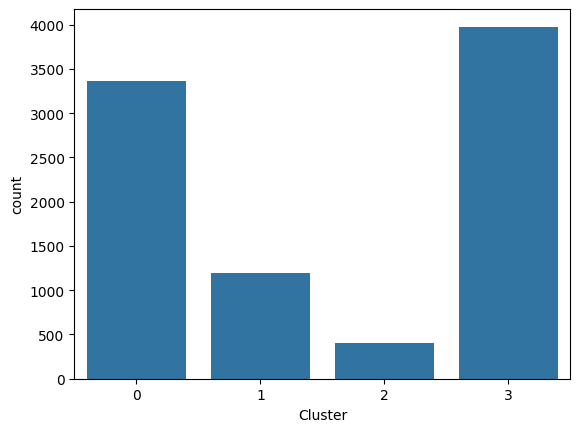

In [34]:
sns.countplot(x='Cluster', data=cluster_df)

In [ ]:
for c in cluster_df.drop(['Cluster'],axis=1):
    grid= sns.FacetGrid(cluster_df, col='Cluster')
    grid= grid.map(plt.hist, c)
plt.show()

In [36]:
import joblib
joblib.dump(kmeans_model, "kmeans_model.pkl")

['kmeans_model.pkl']

In [37]:
cluster_df.to_csv("Clustered_Customer_Data.csv")

In [38]:
X = cluster_df.drop(['Cluster'],axis=1)
y= cluster_df[['Cluster']]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3)

In [ ]:
model= DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
#Confusion_Matrix
print(metrics.confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [40]:
import pickle
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result,'% Accuracy')

0.9325884543761639 % Accuracy


In [ ]:
!pip install streamlit

In [43]:
from sklearn import preprocessing
import streamlit as st
import pandas as pd
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

filename = 'final_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
df = pd.read_csv("Clustered_Customer_Data.csv")
st.set_option('deprecation.showPyplotGlobalUse', False)

st.markdown('<style>body{background-color: Blue;}</style>',unsafe_allow_html=True)
st.title("Prediction")

with st.form("my_form"):
    balance=st.number_input(label='Balance',step=0.001,format="%.6f")
    balance_frequency=st.number_input(label='Balance Frequency',step=0.001,format="%.6f")
    purchases=st.number_input(label='Purchases',step=0.01,format="%.2f")
    oneoff_purchases=st.number_input(label='OneOff_Purchases',step=0.01,format="%.2f")
    installments_purchases=st.number_input(label='Installments Purchases',step=0.01,format="%.2f")
    cash_advance=st.number_input(label='Cash Advance',step=0.01,format="%.6f")
    purchases_frequency=st.number_input(label='Purchases Frequency',step=0.01,format="%.6f")
    oneoff_purchases_frequency=st.number_input(label='OneOff Purchases Frequency',step=0.1,format="%.6f")
    purchases_installment_frequency=st.number_input(label='Purchases Installments Freqency',step=0.1,format="%.6f")
    cash_advance_frequency=st.number_input(label='Cash Advance Frequency',step=0.1,format="%.6f")
    cash_advance_trx=st.number_input(label='Cash Advance Trx',step=1)
    purchases_trx=st.number_input(label='Purchases TRX',step=1)
    credit_limit=st.number_input(label='Credit Limit',step=0.1,format="%.1f")
    payments=st.number_input(label='Payments',step=0.01,format="%.6f")
    minimum_payments=st.number_input(label='Minimum Payments',step=0.01,format="%.6f")
    prc_full_payment=st.number_input(label='PRC Full Payment',step=0.01,format="%.6f")
    tenure=st.number_input(label='Tenure',step=1)

    data=[[balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installment_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure]]

    submitted = st.form_submit_button("Submit")

if submitted:
    clust=loaded_model.predict(data)[0]
    print('Data Belongs to Cluster',clust)

    cluster_df1=df[df['Cluster']==clust]
    plt.rcParams["figure.figsize"] = (20,3)
    for c in cluster_df1.drop(['Cluster'],axis=1):
        fig, ax = plt.subplots()
        grid= sns.FacetGrid(cluster_df1, col='Cluster')
        grid= grid.map(plt.hist, c)
        plt.show()
        st.pyplot(figsize=(5, 5))

2024-04-25 16:24:43.307 
════════════════════════════════════════════════
deprecation.showPyplotGlobalUse IS NO LONGER SUPPORTED.

The support for global pyplot instances is planned to be removed soon.

Please update <user defined>.
════════════════════════════════════════════════

2024-04-25 16:24:43.558 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
